In [25]:
import os
import sys
sys.path.append('models/')
sys.path.append('eval/')
sys.path.append('process_data/')

import libpysal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import scipy
from scipy.stats import poisson, norm, laplace, lognorm

import itertools

# custom GCNN classes
from class_dataset import CTA_Data
from class_gcn_lstm import GCN_LSTM
from class_mve_loss import MVELoss

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import util_gcnn
import util_eval
import util_plot
from setup import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 11})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def post_process_dist(dist, loc, scale):
    
    if dist == "lognorm":
        out_predict = np.exp(loc - np.power(scale,2))
        out_std = np.mean(np.sqrt((np.exp(scale * scale)-1)*(np.exp(2*loc+scale * scale))))
    elif dist == 'tnorm':
        out_predict = loc
        out_std = np.mean(scale)
    elif dist == 'laplace':
        out_predict = loc
        out_std = np.mean(scale) * np.sqrt(2)
    elif dist == 'poisson':
        out_predict = loc
        out_std = np.mean(np.sqrt(loc))
    elif dist == 'norm':
        out_predict = loc
        out_std = np.mean(scale)
        
    return out_predict, out_std
 
    
def post_process_pi(dist, loc, scale, z):
    
    if dist == "lognorm":
#         predict = np.exp(loc - np.power(scale,2))
#         lb = np.exp(predict - z*scale)
#         ub = np.exp(predict + z*scale)
        lb, ub = lognorm.interval(z, loc, scale)
    elif dist == 'tnorm':
#         lb = np.max([0, loc - z*scale])
#         ub = loc + z*scale
        lb, ub = norm.interval(z, loc, scale)
        lb = np.max([0, lb])
    elif dist == 'laplace':
#         predict = loc
#         lb = predict + scale * np.log(2*z)
#         ub = predict - scale * np.log(2-2*(1-z))
        lb, ub = laplace.interval(z, loc, scale)
    elif dist == 'poisson':
        predict = loc
        lb,ub = poisson.interval(z, loc)        
    elif dist == 'norm':
        lb, ub = norm.interval(z, loc, scale)

    return lb, ub

def evaluate(args, dist, dataloader, z, y_eval):
    
    val_out_loc, val_out_scale, val_loss = util_gcnn.testset_output_gcn(dataloader, args.MeanOnly, args.Homoskedastic, net, criterion, 
            adj_torch, spatial_torch, device, n_time)
    val_out_predict, val_out_std = post_process_dist(dist, val_out_loc, val_out_scale)

    val_mae, val_mse, _, _, _ = util_eval.eval_mean(val_out_predict, y_eval, "")

    if args.LossFunc == 'mve':
        lb, ub = post_process_pi(dist, val_out_loc, val_out_scale, z)
        val_mpiw, val_picp = util_eval.eval_pi(lb, ub, y_eval)
    else:
        val_mpiw = 0
        val_picp = 0
        
    return val_loss, val_mae, val_mse, val_mpiw, val_picp, val_out_std, np.mean(val_out_predict)

In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [18]:
project_dir = "/home/jtl/Dropbox (MIT)/project_uncertainty_quantification/"

# parser = argparse.ArgumentParser(fromfile_prefix_chars='@')

# parser.add_argument("-p", "--Period", help="Study period: before/after", type=str, default='before')    
# parser.add_argument("-ph", "--PredictHorizon", help="Predict horizon", default=1)
# parser.add_argument("-ts", "--TimeSize", help="Time aggregation", default=4)
# parser.add_argument("-df", "--Difference", help="Whether to difference", default=1)
# parser.add_argument("-l", "--Lookback", help="Lookback period", default=2)
# parser.add_argument("-a", "--Adj", help="Adjacency matrix type", default=["func","euc","con","net"])
# parser.add_argument("-d", "--Dist", help="Lognorm/Tnorm distribution", default='tnorm')
# parser.add_argument("-ls", "--LossFunc", help="Loss function mve/mse", default='mve')
# parser.add_argument("-m", "--MeanOnly", help="Whether to output mean only or mean+variance", default=0)
# parser.add_argument("-hm", "--Homoskedastic", help="Whether homo or hetero-skedastic variance is estimated", default=0)
# parser.add_argument("-te", "--TrainExtent", help="Training Extent: downtown/all", default='downtown')
# parser.add_argument("-e", "--Epoch", help="Number of training epochs", default=500)
# parser.add_argument("-lr", "--LearningRate", help="Learning rate", default=0.001)
# parser.add_argument("-ms", "--ModelNumberStart", help="Start number of models for each combination of the parameters", type=int, default=-1)
# parser.add_argument("-me", "--ModelNumberEnd", help="End number of models for each combination of the parameters", type=int, default=10)
# parser.add_argument("-s", "--IncludeSpatial", help="Whether to include spatial (demo+poi) information", default=0)
# parser.add_argument("-b", "--Bootstrap", help="Whether to bootstrap training data", default=0)
# parser.add_argument("-of", "--OutFolder", help="Output Folder", default="")
# parser.add_argument("-sv", "--Save", help="Whether to save models", default=0)

# args = parser.parse_args(['@arguments.txt'])

# args.Period = args.Period.split(',')
# args.Lookback = [int(x) for x in args.Lookback.split(',')]
# args.Dist = args.Dist.split(',')
# args.Difference = bool(int(args.Difference))
# args.MeanOnly = bool(int(args.MeanOnly))
# args.Homoskedastic = bool(int(args.Homoskedastic))
# args.IncludeSpatial = bool(int(args.IncludeSpatial))
# args.Save = bool(int(args.Save))
# args.Bootstrap = bool(int(args.Bootstrap))

args = dotdict({"Period": ['before'],
       "OutFolder":"220405",
       "Lookback":[2,4,6],
       "Dist":["norm"],
       "MeanOnly":False,
       "ModelNumberStart":0,
       "ModelNumberEnd":1,
       "Adj":["func","euc","con","net"],
       "Save":False,
       "PredictHorizon":1,
       "TimeSize":4,
       "Difference":True,
       "LossFunc":"mve",
       "Homoskedastic":False,
       "TrainExtent":"downtown",
       "Epoch":501,
       "LearningRate":0.001,
       "IncludeSpatial":False,
       "Bootstrap":False})

dropout_rate_list=[0.2,0.5]
n_hid_units_list=[64,128]
weight_decay_list = [0.0001, 0.001, 0.01, 0.1]
ngc_list = [1,2]
nlstm_list = [1,2]
hps = list(itertools.product(dropout_rate_list, n_hid_units_list, weight_decay_list, nlstm_list, ngc_list))
max_lookback = 6


if args.ModelNumberStart == -1:
    run_all = True
else:
    run_all = False

predict_hzn = args.PredictHorizon
time_size = args.TimeSize
difference = args.Difference
adj_type = args.Adj
train_extent = args.TrainExtent

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
z = 0.95
n_time = 96 // time_size - 7


In [29]:
for (period, dist) in itertools.product(args.Period, args.Dist):

    writer_hp = SummaryWriter(project_dir+"tensorboard/runs/test_"+args.OutFolder+"_"+period+"_"+dist+"/")

    for lookback in args.Lookback:

        print("Period:", period, "Predict Horizon:", predict_hzn, "Time Size:", time_size, "Lookback:", lookback, "\nadj:", '_'.join(adj_type), "Dist:", dist, "Train Extent:", train_extent)

        data, adj, spatial, downtown_filter = \
                util_gcnn.combine_datasources(project_dir, period, predict_hzn, time_size, difference, max_lookback, lookback)

#         device = torch.device("cpu")
        trainloader, trainloader_test, valloader, testloader, adj_torch, spatial_torch, y_train_eval, y_val_eval, y_test_eval = \
                util_gcnn.prepare_for_torch(device, train_extent, data, adj, spatial, downtown_filter, adj_type, bootstrap=args.Bootstrap)
        (num_train, _, _, n_modes) = data['x'][0].shape
        num_test = len(y_test_eval)
        num_val = len(y_val_eval)
        n_stations = adj_torch.shape[0]
        y_train_eval = np.squeeze(y_train_eval)
        y_val_eval = np.squeeze(y_val_eval)
        y_test_eval = np.squeeze(y_test_eval)

        same_hp = False
        if not args.IncludeSpatial:
            spatial_torch = None
            ndemo = 0
        else:
            ndemo = spatial.shape[1]

        if run_all:
            if os.path.isfile(project_dir+"results/"+args.OutFolder+"_"+period+"/results.csv"):
                results = pd.read_csv(project_dir+"results/"+args.OutFolder+"_"+period+"/results.csv")
                hp_run = results[(results['Period']==period)&(results['Distribution']==dist)&(results['Predict Horizon']==predict_hzn)&(results['Time Size']==time_size)&(results['Adjacency']=='_'.join(adj_type))& \
                        (results['Lookback']==lookback)&(results['Train Extent']=='downtown')&(results['spatial']==int(args.IncludeSpatial))] 
            else:
                hp_run = []

            if len(hp_run) != 0:
                model_offset = hp_run['Model'].max()+1
                hp_run = hp_run[['dropout','n_hid_units','weight_decay','nlstm','ngc']].to_numpy()
                hp_run = [tuple(l) for l in hp_run]
            else:
                model_offset = 0

            args.ModelNumberStart = 0
            args.ModelNumberEnd = len(hps)
            model_offset_2 = 0
        else:
            model_offset = 0
            model_offset_2 = 0


        for ii in range(args.ModelNumberStart, args.ModelNumberEnd):

            if run_all: 
                hp_index = ii
                if hps[hp_index] in hp_run:
                    model_offset_2 += 1
                    continue
            else:
                hp_index = np.random.choice(np.arange(0, len(hps)))

            save_dir = project_dir+"models/"+args.OutFolder+"_"+period+"_"+dist+"/"
            if not os.path.isdir(save_dir):
                os.mkdir(save_dir)

            save_dir += train_extent+"_"+'-'.join(adj_type)+"_"+str(predict_hzn)+"_"+str(time_size)+"_"+str(lookback)+"_"+str(ii+model_offset-model_offset_2)
            writer = SummaryWriter(project_dir+"tensorboard/runs/"+args.OutFolder+"_"+period+"_"+dist+"_train/"+str(lookback)+"_"+str(ii+model_offset-model_offset_2)+"/")

            best = 0
            best_epoch = 0

            dropout = hps[hp_index][0]
            n_hid_units = hps[hp_index][1]
            weight_decay = hps[hp_index][2]
            nlstm = hps[hp_index][3]
            ngc = hps[hp_index][4]

            print('Model ', ii+model_offset-model_offset_2)

            if args.LossFunc == 'mve':
                criterion = MVELoss(dist)
            elif args.LossFunc == 'mse':
                criterion = nn.MSELoss()
            else:
                print("loss function not valid.")
                sys.exit()

            net = GCN_LSTM(meanonly=args.MeanOnly, homo=args.Homoskedastic, nadj = len(adj_type), nmode=n_modes, nstation=n_stations, ntime=n_time, 
                    ndemo=ndemo,
                    nhid_g=n_hid_units, ngc=ngc, nhid_l=n_hid_units, nlstm=nlstm, 
                    nhid_fc=n_hid_units, dropout=dropout)
            net.to(device)

            optimizer = optim.Adam(net.parameters(), lr=args.LearningRate, weight_decay=weight_decay)
            ref1 = 0
            ref2 = 0
            success=True

            for epoch in range(args.Epoch):

                running_loss = 0.0

                for i, batch_data in enumerate(trainloader, 0):

                    net.train()

                    # get the inputs; data is a list of [inputs, labels, history, quarter of the day]
                    batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod = batch_data
                    batch_size=len(batch_x)

                    batch_x = batch_x.float()
                    batch_y = torch.squeeze(batch_y).float()
                    batch_history = batch_history.float()
                    batch_qod = batch_qod.view(-1,1)
                    batch_qod_onehot = torch.FloatTensor(batch_size, n_time)
                    batch_qod_onehot.zero_()
                    batch_qod_onehot.scatter_(1, batch_qod-6, 1)
                    if dist == 'lognorm':
                        batch_history = torch.log(batch_history+0.00001)

                    batch_x, batch_y, batch_history, batch_weather, batch_los, batch_qod_onehot = \
                            batch_x.to(device), batch_y.to(device), batch_history.to(device), \
                            batch_weather.to(device), batch_los.to(device), batch_qod_onehot.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward 
                    outputs = net(batch_x, None, adj_torch, batch_history, spatial_torch, 
                            batch_weather, batch_los, batch_qod_onehot, 1)

                    if args.MeanOnly:
                        output_loc = outputs
                        loss = criterion(output_loc, target=batch_y)
                    else:
                        if not args.Homoskedastic:
                            output_loc = outputs[:batch_size,:]
                            output_scale = outputs[batch_size:,:]
                        else:
                            output_loc, output_scale = outputs

                        loss = criterion(output_loc, output_scale, batch_y)

                    # backward
                    loss.backward()

                    # optimize
                    optimizer.step()

                    running_loss += loss.item()

                    if torch.sum(torch.isnan(output_loc)) > 0:
                        success=False
                        break

                if not success:
                    break

                if epoch % 5 == 0:
#                     print('[%d] training loss: %.3f' %
#                             (epoch + 1, running_loss/num_train), end = '\t')
                    net.eval()

                    tr_loss, tr_mae, tr_mse, tr_mpiw, tr_picp,a,b = evaluate(args, dist, trainloader_test, z, y_train_eval)

                    writer.add_scalar("Loss/Train", running_loss/num_train, epoch+1)
                    writer.add_scalar("MAE/Train", tr_mae, epoch+1)
                    writer.add_scalar("MPIW/Train", tr_mpiw, epoch+1)
                    writer.add_scalar("PICP/Train", tr_picp, epoch+1)


                    val_loss, val_mae, val_mse, val_mpiw, val_picp,c,d = evaluate(args, dist, valloader, z, y_val_eval)

                    writer.add_scalar("Loss/Validation", val_loss/num_val, epoch+1)
                    writer.add_scalar("MAE/Validation", val_mae, epoch+1)
                    writer.add_scalar("MPIW/Validation", val_mpiw, epoch+1)
                    writer.add_scalar("PICP/Validation", val_picp, epoch+1)

                    test_loss, test_mae, test_mse, test_mpiw, test_picp,_,_ = evaluate(args, dist, testloader, z, y_test_eval)

                    writer.add_scalar("Loss/Test", test_loss/num_val, epoch+1)
                    writer.add_scalar("MAE/Test", test_mae, epoch+1)
                    writer.add_scalar("MPIW/Test", test_mpiw, epoch+1)
                    writer.add_scalar("PICP/Test", test_picp, epoch+1)
                    
                    print(tr_loss/num_train, val_loss/num_val, test_loss/num_test)
#                           print(a,b,c,d)
                    if epoch > 40:
                        if running_loss < best:
                            best = running_loss
                            best_epoch = epoch
                            output_string = (tr_loss/num_train, tr_mae, tr_mse, tr_mpiw, tr_picp,
                                val_loss/num_val, val_mae, val_mse, val_mpiw, val_picp,
                                test_loss/num_test, test_mae, test_mse, test_mpiw, test_picp)
                        if (np.abs(running_loss - ref1)/ref1<0.005) & (np.abs(running_loss - ref2)/ref2<0.005):
                            print("early stopping at epoch", epoch)
                            break
                        if (ref1 < running_loss) & (ref2 < ref1):
                            print("diverging. stop.")
                            break

                    else:
                        best = running_loss
                        best_epoch = epoch
                        output_string = (tr_loss/num_train, tr_mae, tr_mse, tr_mpiw, tr_picp,
                                val_loss/num_val, val_mae, val_mse, val_mpiw, val_picp,
                                test_loss/num_test, test_mae, test_mse, test_mpiw, test_picp)

                    ref2 = ref1
                    ref1 = running_loss

                    if (args.Save) & (best_epoch==epoch):
                        torch.save({'epoch': epoch,
                            'model_state_dict': net.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'hyperparameters': (period, train_extent, train_extent, '_'.join(adj_type), ii, 
                                predict_hzn, time_size, lookback, 
                                dropout, n_hid_units, nlstm, ngc, weight_decay, args.Bootstrap)},
                            save_dir+"_"+str(epoch)+".pt")

                        files = glob.glob(save_dir+"_*.pt")

            if args.Save:
                for f in files:
                    e = int(f.split("_")[-1].split(".")[0])
                    if e != best_epoch:
                        os.remove(f)
                    else:
                        net.load_state_dict(torch.load(f)['model_state_dict'])

            if not success:
                print("trainig failed ", str(ii+model_offset-model_offset_2))
            else:
                print('finished training ', str(ii+model_offset-model_offset_2))

            hparams_dict = {'train_extent':train_extent, 'adjacency': '_'.join(adj_type), 
                                'prediction_horizon': predict_hzn, 'time_size': time_size, 'lookback': lookback, 
                                'dropout': dropout, 'n_hid_units': n_hid_units, 'nlstm': nlstm, 'ngc': ngc, 'weight_decay': weight_decay, 'bootstrap': args.Bootstrap}
            metrics_dict = {"loss_train": tr_loss/num_train, "mae_train": tr_mae, "mse_train": tr_mse, "mpiw_train": tr_mpiw, "picp_train": tr_picp,
                                "loss_val": val_loss/num_val, "mae_val": val_mae, "mse_val": val_mse, "mpiw_val": val_mpiw, "picp_val": val_picp,
                                "loss_test": test_loss/num_test, "mae_test": test_mae, "mse_test":test_mse, "mpiw_test": test_mpiw, "picp_test": test_picp}
            writer_hp.add_hparams(hparams_dict, metrics_dict, run_name = str(lookback)+"_"+str(ii+model_offset-model_offset_2))

            # Write to File
#             if not os.path.isdir(project_dir+"results/"+args.OutFolder+"_"+period+"/"):
#                 os.mkdir(project_dir+"results/"+args.OutFolder+"_"+period+"/")
#             with open(project_dir+"results/"+args.OutFolder+"_"+period+"/results.csv","a") as f:
#                 f.write("%s,%s,%s,%s,%s,%s,%d,%d,%d,%d,%d,%.2f,%d,%d,%d,%.2E,%d,%.2f,%.2f,%.2f,%.6f,%.6f,%.2f,%.2f,%.2f,%.6f,%.6f,%.2f,%.2f,%.2f,%.6f,%.6f\n" % 
#                        (("GCN", period, dist, train_extent, train_extent, '_'.join(adj_type), ii+model_offset-model_offset_2, 
#                             predict_hzn, time_size, lookback, args.Bootstrap, 
#                             dropout, n_hid_units, nlstm, ngc, weight_decay, spatial_torch is not None) + output_string))
        break
    break

Period: before Predict Horizon: 1 Time Size: 4 Lookback: 2 
adj: func_euc_con_net Dist: norm Train Extent: downtown
Model  0
192.17734932412907 107.42048311781609 705.1171428571429
129.85020182084065 110.65730513649426 130.91685267857142
108.39854820407167 94.19368489583333 101.55861607142857
103.82446148930764 94.01558010057471 98.18325892857143
101.7747525584941 93.50787984913794 95.95748883928572
100.85904444480428 93.06757363505747 94.97970982142857
100.17998644770408 93.54054418103448 95.375
99.56615167734574 93.13671875 94.77073660714285
99.30729426169881 93.23847207255747 94.83165178571429
98.85267000782247 93.032400547773 94.66758928571429
98.36898243183992 92.70913029813218 94.28159598214286
98.46906887755102 93.42401894755747 95.07435267857143
diverging. stop.
finished training  0


In [53]:
ref1/num_train

99.16627066476005

In [54]:
ref2/num_train

100.13407570975167

In [51]:
running_loss/num_train

99.29035202337771

In [45]:
for name in net.named_parameters():
    if name[0] == 'recent_on_history_mean.weight':
        print('mean', torch.mean(name[1], dim=1))
    if name[0] == 'recent_on_history_var.weight':
        print('var', torch.mean(name[1], dim=1))
        break

mean tensor([0.0295, 0.0266, 0.0297, 0.0371, 0.0340, 0.0344, 0.0307, 0.0279, 0.0292,
        0.0262, 0.0264, 0.0290, 0.0274, 0.0274, 0.0231, 0.0272, 0.0282, 0.0289],
       device='cuda:1', grad_fn=<MeanBackward1>)
var tensor([ 0.0127,  0.0009,  0.0078,  0.0034, -0.0033,  0.0098,  0.0060,  0.0066,
         0.0119,  0.0017,  0.0111,  0.0034,  0.0103,  0.0124,  0.0069, -0.0057,
         0.0005, -0.0040], device='cuda:1', grad_fn=<MeanBackward1>)


In [46]:
name[1]

Parameter containing:
tensor([[-0.0312,  0.1071,  0.0418,  ..., -0.0236, -0.0580, -0.1784],
        [-0.0317,  0.0395,  0.0306,  ..., -0.0522, -0.0338, -0.2485],
        [-0.0413,  0.1077,  0.0043,  ..., -0.0255, -0.0639, -0.1668],
        ...,
        [-0.0228, -0.0427, -0.0920,  ..., -0.1438, -0.0361, -0.1915],
        [-0.0048,  0.0544,  0.0543,  ..., -0.1015, -0.0106, -0.1850],
        [-0.0245,  0.0557,  0.0473,  ..., -0.0513, -0.0216, -0.2430]],
       device='cuda:1', requires_grad=True)

In [49]:
a = util_gcnn.testset_output_gcn(valloader, args.MeanOnly, args.Homoskedastic, net, criterion, 
            adj_torch, spatial_torch, device, n_time, return_components=True)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.2778, 0.0000, 0.3774],
         [0.0000, 0.0000, 0.0000,  ..., 0.2021, 0.0000, 0.7780]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.2021, 0.0000, 0.7780],
         [0.0000, 0.0000, 0.0000,  ..., 0.2912, 0.0000, 0.1939]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.2912, 0.0000, 0.1939],
         [0.1686, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0616]],

        [[0.1686, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0616],
         [0.0026, 0.0000, 0.0000,  ..., 0.0921, 0.0000, 0.7103]],

        [[0.0026, 0.0000, 0.0000,  ..., 0.0921, 0.0000, 0.7103],
         [0.0000, 0.0000, 0.0000,  ..., 0.2032, 0.0000, 1.5568]]],
       device='cuda:1', grad_fn=<SliceBackward0>)
tensor([4.4625, 4.2414, 5.0716, 4.5212, 4.3018, 4.6418, 4.5233, 3.8145, 4.4233,
        3.9323, 4.2319, 4.2283, 3.7733, 4.1148, 4.2311, 3.9268, 3.5367, 4.1300],
       device='cuda:1', grad_fn=<SliceBackward0>)
tensor([-2.5302, -2.6935, -2.7310, -1.5050, -1.7864, -1.3491, -2.3787, -2.5465,

In [41]:
me = a[0]

mv = a[1]

for i in me:
    print(torch.mean(i))

for i in mv:
    print(torch.mean(i))

tensor(12.6614, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(499.4590, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.0025, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(-0.0342, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(16.9579, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(103.3378, device='cuda:1', grad_fn=<MeanBackward0>)
tensor(0.0224, device='cuda:1', grad_fn=<MeanBackward0>)


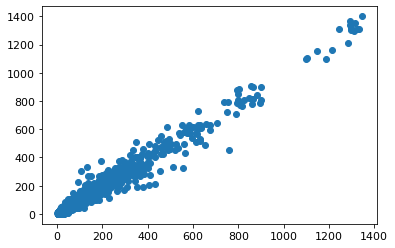

In [18]:
plt.scatter(test_out_predict, y_test_eval)

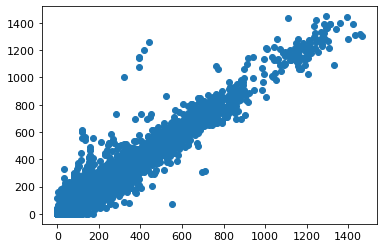

In [17]:
plt.scatter(train_out_predict, y_train_eval)